In [5]:
# Data manipulation
import numpy as np
import pandas as pd

# For saving dictionaries
import pickle

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Time series splitting for walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Neural network portfolio optimizer and objective functions
from workflow.tools.leverage_models import LSTMPortOpt_L, AttentionLSTMPortOpt_L, CNNPortOpt_L
from workflow.tools.metrics import neg_sharpe_ratio

# Transaction costs
from workflow.tools.transaction_costs import net_tc

# Tensor transform
from workflow.tools.conversion import to_tensors

from workflow.tools.utils import set_plot_style, plot_allocations

set_plot_style()

In [6]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282080,44.861336,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487652,21.191517,45.184078,12.83,-0.000498,-0.004264,0.007168,-0.057548
2006-02-09,58.522652,21.390755,45.098019,13.12,0.000598,0.009358,-0.001906,0.022352
2006-02-10,58.399944,21.001339,45.191254,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440830,20.675316,44.986858,13.35,0.000700,-0.015646,-0.004533,0.036617


In [7]:
# Define lookback window
lookback = 50
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X[i-lookback] = features.iloc[i-lookback:i]

X.shape, y.shape

((4403, 50, 8), (4403, 4))

In [8]:
# Set random seed (torch) for reproducibility
torch.manual_seed(42)

# Initialize models dictionary
models = {
    "LSTM": LSTMPortOpt_L,
    "AttentionLSTM": AttentionLSTMPortOpt_L,
    "CNN": CNNPortOpt_L
}

# Initialize empty weights dictionary
weights = {model: [] for model in models.keys()}

# Define number of trading days per year and initialize TimeSeriesSplit
trading_days = 252
retrain_after = 2
tss = TimeSeriesSplit(test_size=trading_days*retrain_after)
val_size = .2

# Loop over model
for a, (name, model_) in enumerate(models.items()):
    
    print(f"{a+1}: {name}", end="\n")

    for e, (train_idx, test_idx) in enumerate(tss.split(X)):
        
        val_idx = int(len(train_idx) * (1 - val_size))
        
        # Split data
        X_train, X_val, X_test = X[:val_idx], X[val_idx:], X[test_idx]
        y_train, y_val, y_test = y[:val_idx], y[val_idx:], y[test_idx]

        # Convert inputs and targets to PyTorch tensors
        X_train, X_val, X_test, y_train, y_val, y_test = to_tensors(
            X_train, X_val, X_test, y_train, y_val, y_test
        )

        # Define input size, hidden size, and output size
        input_size = X_train.shape[-1]       # 8 features
        hidden_size = 64                     # 64 neurons
        output_size = y_train.shape[-1]      # 4 assets

        # Instantiate model and optimizer
        if name == "AttentionLSTM":
            attention_size = 0.1
            model = model_(input_size, hidden_size, output_size, attention_size)
        else:
            model = model_(input_size, hidden_size, output_size)

        optimizer = torch.optim.Adam(model.parameters())

        # Define number of epochs
        epochs = 100

        # Construct training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            obj = neg_sharpe_ratio(outputs, y_train)
            obj.backward()
            optimizer.step()

            # Evaluate validation performance
            with torch.no_grad():
                val_allocations = model(X_val)
                val_obj = neg_sharpe_ratio(val_allocations, y_val)
            
            print(
                f"Split {e+1}: Epoch {epoch+1}/{epochs} ({(epoch+1)/epochs*100:,.2f}%)",
                "|",
                f"Train: {obj.item():,.5f}", 
                f"Val: {val_obj.item():,.5f}" ,
                end="\r"
            )

        print()
        
        # Get the outputs (asset allocations) after training
        with torch.no_grad():
            model_allocations = model(X_test)
            weights[name].append(model_allocations)
    
    print()

1: LSTM


In [ ]:
# Backtest optimized portfolios
backtest = []

for name, weights_ in weights.items():
    weights = np.concatenate(weights_)
    
    # Reindex features to match weights
    reindexed_features = features.iloc[-len(weights):]
    weights = pd.DataFrame(weights, index=reindexed_features.index, columns=indices)

    # Shift weights for real time information lag
    weights = weights.shift().dropna()

    reindexed_returns = reindexed_features[return_cols][1:]
    reindexed_returns.columns = indices

    # Portfolio returns = sum of (weights * returns)
    returns = (weights * reindexed_returns).sum(axis=1)
    returns = net_tc(returns, weights, cost_rate=0.005)
    returns.name = name
    backtest.append(returns)

backtest = pd.concat(backtest, axis=1)
backtest["STOCK_MARKET"] = features[return_cols].reindex(backtest.index)
backtest.loc[backtest.index.min()] = 0

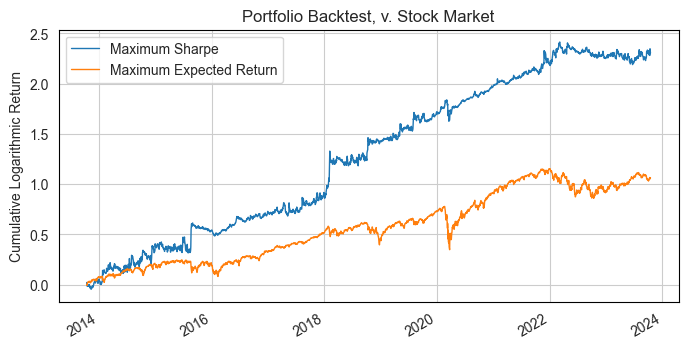

In [ ]:
backtest.cumsum().plot(figsize=(8, 4))
plt.title("Portfolio Backtest, v. Stock Market")
plt.ylabel("Cumulative Logarithmic Return")
plt.xlabel("")
plt.legend(["Maximum Sharpe", "Maximum Expected Return", "Minimum Variance", "Stock Market (VTI)"])
plt.show()

In [ ]:
optimized_stats = PortfolioStats(backtest, log=True)

optimized_stats.info.sort_values(by="SHARPE", ascending=False)

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
MAX_SHARPE,0.870916,2.305544,0.230646,0.264832,-0.224724
STOCK_MARKET,0.594404,1.063772,0.106419,0.179036,-0.430787


In [ ]:
for col in optimized_stats.info.columns:
    print("--", col, "--")
    print(optimized_stats.info[col].sort_values(ascending=False)[:1])
    print()

-- SHARPE --
MAX_SHARPE    0.870916
Name: SHARPE, dtype: object

-- CUMU_RET --
MAX_SHARPE    2.305544
Name: CUMU_RET, dtype: object

-- ANN_RET --
MAX_SHARPE    0.230646
Name: ANN_RET, dtype: object

-- ANN_VOL --
MAX_SHARPE    0.264832
Name: ANN_VOL, dtype: object

-- MAX_DD --
MAX_SHARPE   -0.224724
Name: MAX_DD, dtype: object



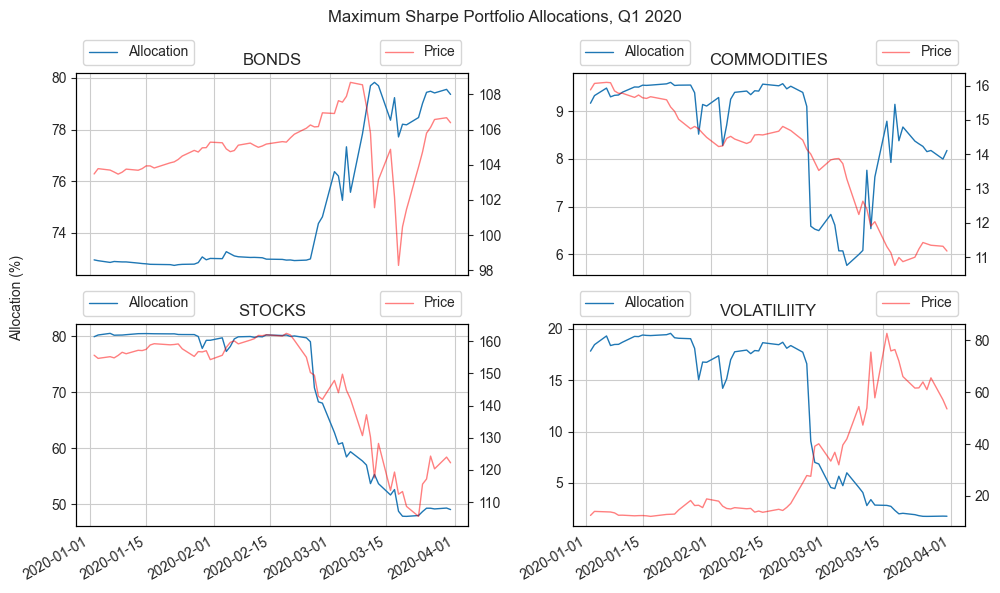

In [ ]:
covid_q1 = {"start": "2020-01", "end": "2020-03"}

titles = [
    "Maximum Sharpe Portfolio Allocations, Q1 2020",
    "Maximum Expected Return Portfolio Allocations, Q1 2020",
    "Minimum Variance Portfolio Allocations, Q1 2020",
]

for i, opt_type in enumerate(optimizations.keys()):
    plot_allocations(optimizations[opt_type], features, indices, covid_q1, titles[i])

In [ ]:
# Save files
backtest.to_csv("workflow/data/backtests/lstm_lev_bt.csv")
with open("workflow/data/optimizations/lstm_lev_opt.pkl", "wb") as f:
    pickle.dump(optimizations, f)

In [ ]:
!pip install --upgrade ipykernel